# <span style="color:red"> Numerical Simulation Laboratory (NSL) </span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

seed = 0
np.random.seed(seed)

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(seed)
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from PIL import Image
from keras.models import Model
import os
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

2024-04-19 17:25:46.271378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 17:25:46.722902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 17:25:46.727486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 17:25:47.938336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1><font color='ForestGreen'>ESERCITAZIONE 12: Deep Learning e Classificazione Immagini </font> </h1>

<h3><font color = 'LightGreen'>Intro</font></h3>

In breve, in questa esercitazione l'obiettivo e' impiegare le reti neurali al fine di classificare un dataset di cifre da 0 a 9 estratte dal database MNIST: per farlo, si fa utilizzo delle reti neurali convoluzionali.
Per effettuare il training delle reti neurali, si fa uso del database MNIST : un database che contiene 
cifre scritte a mano, ciascuna delle quali rappresentata da una immagine quadrata divisa in una griglia di 28x28 pixel. Ogni pixel si puo' trovare in 256 stati di gradazione del grigio, cioe' dal bianco al nero, il che significa che ogni punto della griglia puo' assumere un qualsiasi valore in $\{0,1,\dots,255\}$.
Per fare questo lavoro di ricoscimento e classificazione di cifre scritte a mano, si impiega un modello di deep neural network prima e di convolutinal neural network poi: tutto quanto sfruttando la libreria Keras di Python.
In generale, senza entrare troppo in dettaglio, si puo' dire che i DNN sono costituiti da vari layer di neuroni e sono, all'infuori del layout definito in funzione del problema, completamente equivalenti alle reti costruite nell'esercitazione precedente per la risoluzione di problemi. Al contrario, i CNN rappresentano si' sempre un approccio di tipo supervised learning, ma con delle notevoli differenze: in pratica sono architetture che sfruttano le simmetrie fisiche per diventare piu' efficienti. Essi usano filtri e layer di pooling per eccellere in compiti come l'image processing.
In punto essenziale di questi tipi di network e' che la parte principale dell'ottimizzazione stocastica non consiste solo nel trovare pesi e bias adatti, bensi' nel trovare il tipo e il numero di filtri da utilizzare.


<h2><font color = 'LimeGreen'>ESERCIZIO 12.1: Classificazione Immagini</font></h2>

Partendo da un codice gia' funzionante, il primo compito che ci si propone e' andare ad ottimizzare la rete studiando il comportamento delle loss, dell'accuratezza e le predizioni del network al variare del numero di epoche e dell'ottimizzatore scelto. La funzione costo  categorical crossentropy e la funzione di attivazione la relu viceversa sono tenute fissate.
Per quanto concerne il numero di batch, cioe' quanti dati usiamo per calcolare un gradiente aprossimato che ci indica la direzione di spostamento per la nostra ottimizzazione, e' anch'esso definito e posto uguale a 32 in tutti i casi.
Mentre la funzione costo e l'ottimizzatore sono essenziali per la procedura di training, per testare le performance abbiamo scelto di osservare la accuracy, dato che affrontiamo un problema di classificazione, che e' definita come la percentuale di dati correttamente classificati.

Il network implementato e' costituito da tre layer: il primo di 400 neuroni con input shape 784, cioe' le immagini 28x28 rese vettori, il secondo e il terzo da 100 neuroni; abbiamo poi un layer di dropout per aiutare la rete a generalizzare e come output un layer costituito da 10 neuroni, come le 10 categorie da riconoscere, con funzione di attivazione la softmax per trasformare in probabilita' le componenti del vettore.

Di sotto riportiamo i risultati: loss, accuracy e predizioni sono raccolte in gruppi e plottate insieme.


Costruiamoci dapprima lo scheletro delle rete neurale, i cui valori dovranno essere ottimizzati:

In [3]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5, cioe' ne spengo la meta': questo layer funziona solo nel training
    #quindi e' plausibile che la loss sul test sia minore di quella del train perche' nel test usa tutti i neuroni
    model.add(Dropout(0.5))
    #Dropout E' UN UTILE E POTENTE METODO. PERMETTE ALLA RETE DI FIDARSI TROPPO DI UNA STRUTTURA NEURONALE CHE  
    #IMPARA RIGIDAMENTE E A PARTIRE DA SOLO QUELLO CHE HA VISTO.
    
    # soft-max layer: mi rende probabilita' le componenti di questo vettore di 10 componenti
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


Le reti neurali particolarmete articolate e complesse tendono ad avere overfitting. Per attenuare tale problema si usa la funzionalita' intrinseca della libreria keras: questa passa sotto il nome Dropout. In questo modo, si seleziona in modo casuale e si spengono delle connessioni tra i nodi con un certo tasso (50%).
Questo impedisce che l'accuratezza del modello di training sia troppo diversa da quella di test.

Definiamo la funzione per fissare l'ottimizzatore, la loss e la metrica:

In [4]:
def compile_model(choosen_optimizer): #standard optimizer=SGD()
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, #la categorical tende a zero quando azzecco la label
                  optimizer=choosen_optimizer, metrics=['accuracy'])
    return model


L'ultimo metodo da definire è la metrica che quantifica la performance del modello. È stata scelta la funzionalità accuracy.

I dati usati invece sono:

In [5]:
# DATI:
batch_size = 32 
epochs = [8,16, 24] #std=5
optimizers = ['sgd', 'Adadelta','Adam', 'Nadam'  ] #adam e' sgd con momenti, nadam col momento di nesterov
# NB: NELLA DOCUMENTAZIONE SI TROVA CHE adadelta HA LEARNING RATE DI DAFAULT = 0.001 

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits


Notiamo che nella fase di training si addestra la rete, ovvero si individuano i migliori pesi per ogni nodo. Si ripete tale procedura per un numero di volte pari alle epoche su dati divisi in sottogruppi di dimensione batch_size.

Quindi, al variare di epoche ed ottimizzatori, si ha:

2024-04-19 17:25:56.282775: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Test loss: 0.12292724847793579
Test accuracy: 0.9620000123977661


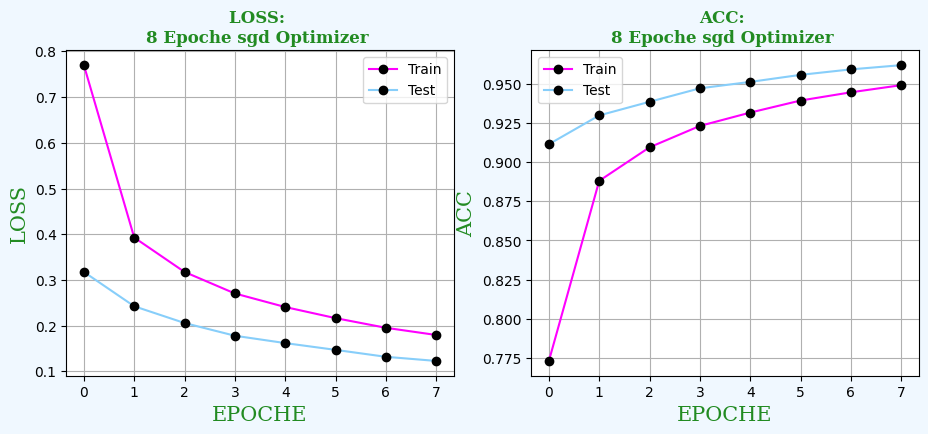

313/313 [==============================] - 1s 2ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


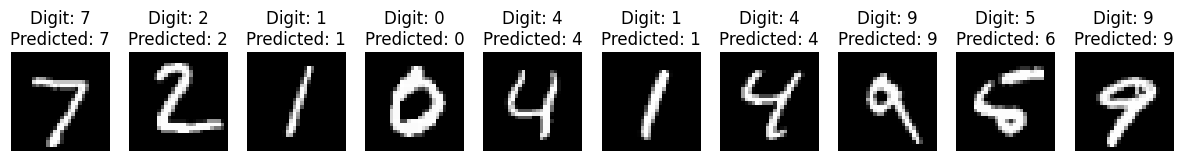

2024-04-19 17:26:57.347217: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Test loss: 1.104521632194519
Test accuracy: 0.8004000186920166


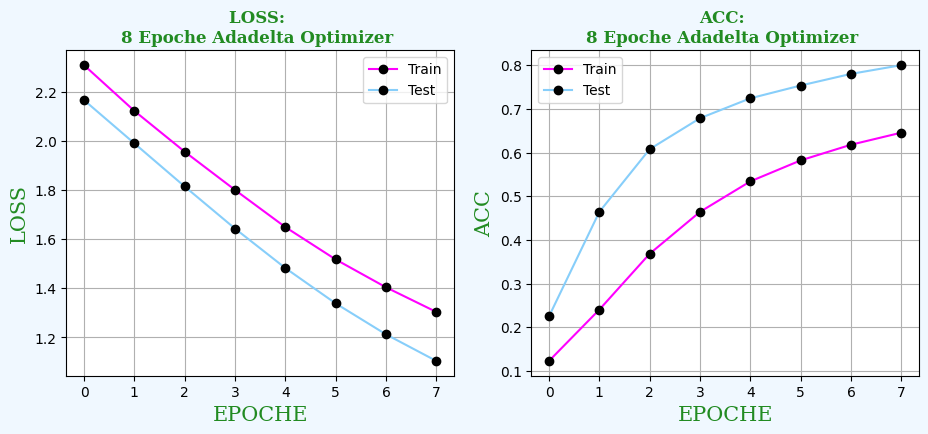

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


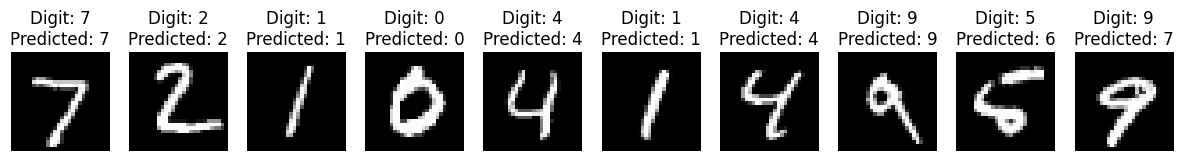

2024-04-19 17:28:49.430531: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Test loss: 0.08045503497123718
Test accuracy: 0.9811000227928162


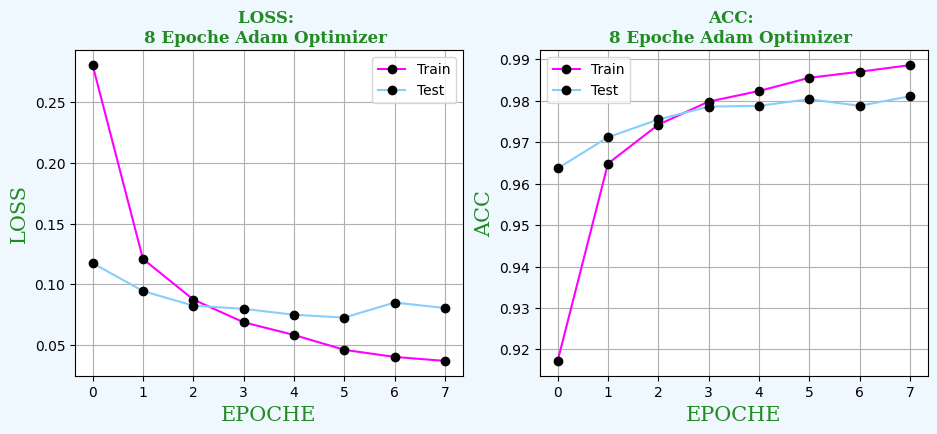

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


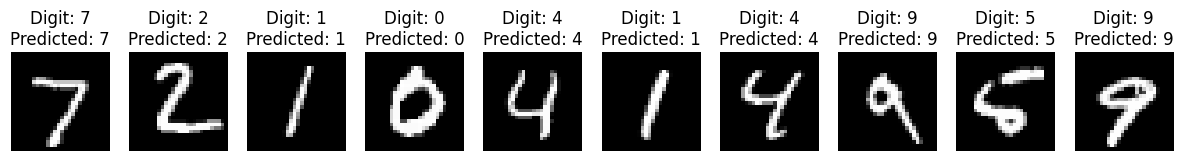

2024-04-19 17:30:30.671498: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Test loss: 0.07866371423006058
Test accuracy: 0.9805999994277954


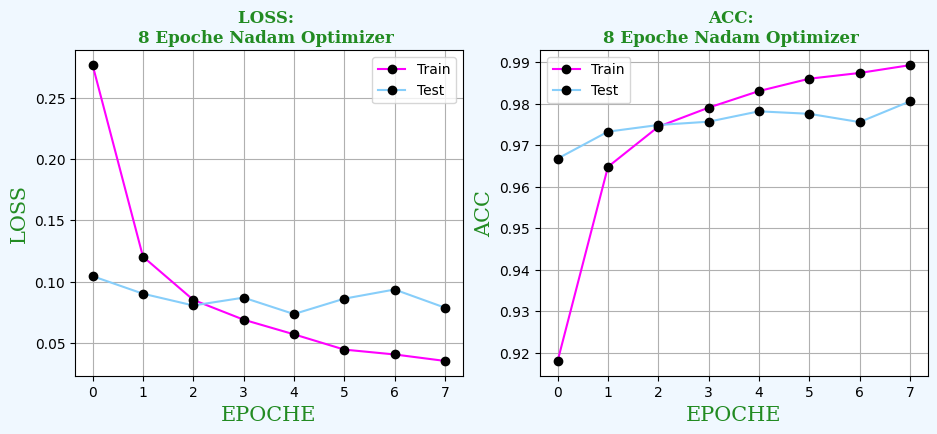

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


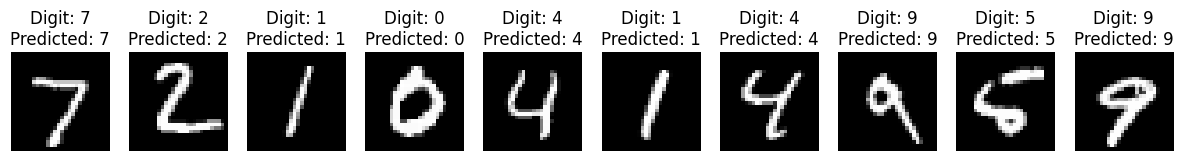

2024-04-19 17:32:19.963833: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Test loss: 0.08729080855846405
Test accuracy: 0.9726999998092651


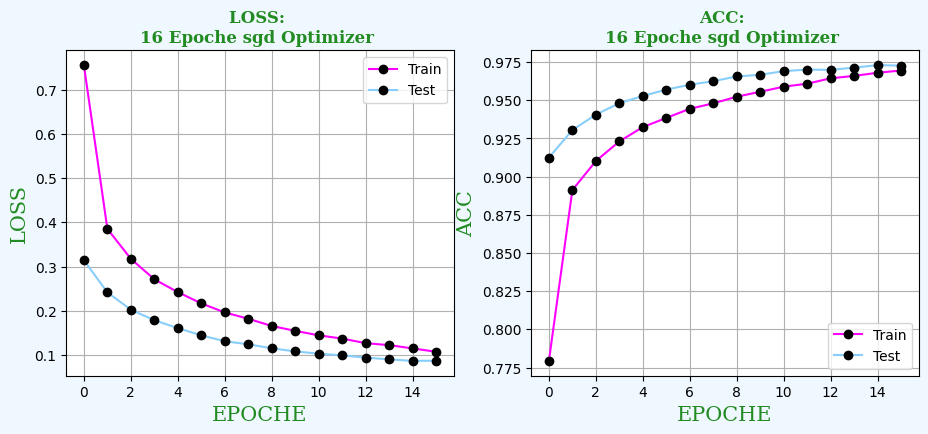

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


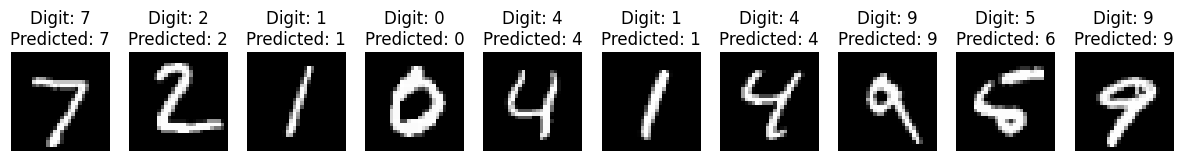


Test loss: 0.6790689826011658
Test accuracy: 0.8593000173568726


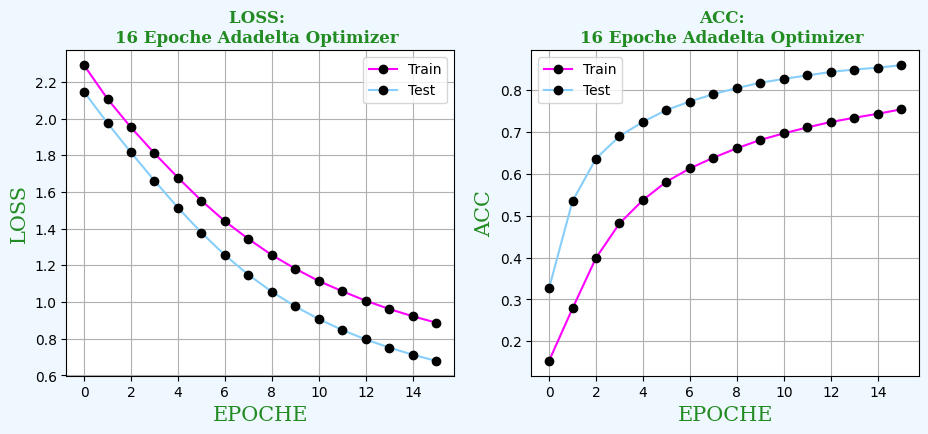

313/313 [==============================] - 1s 2ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


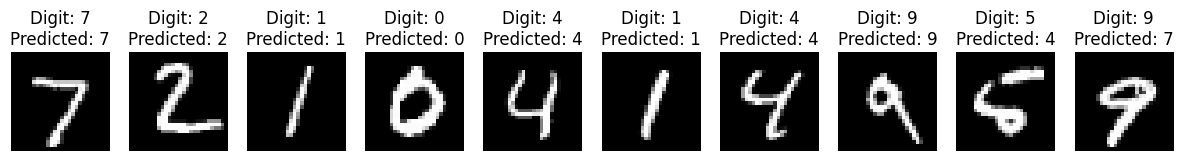


Test loss: 0.11624765396118164
Test accuracy: 0.9790999889373779


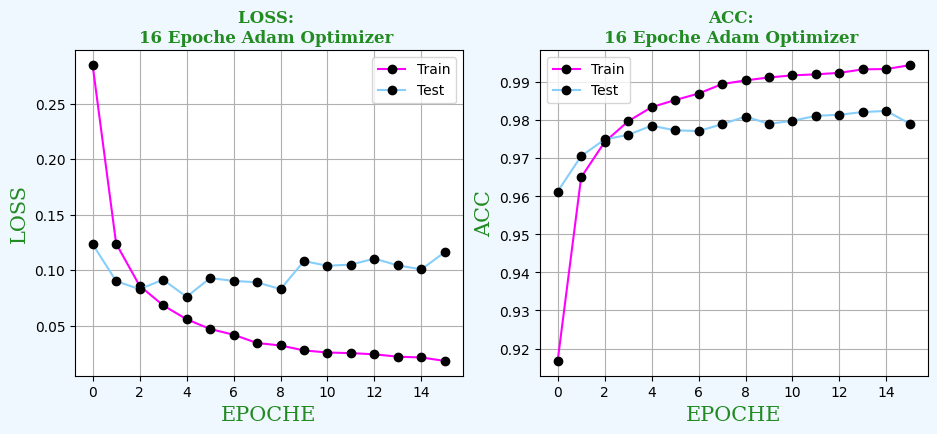

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


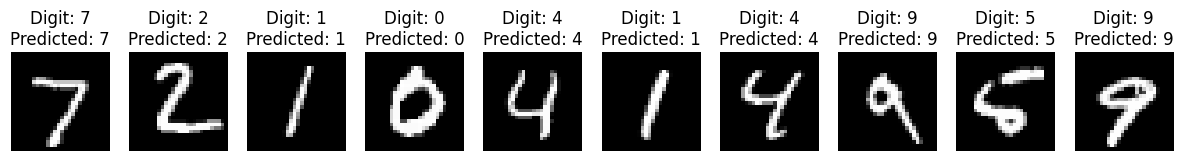


Test loss: 0.10582190006971359
Test accuracy: 0.9821000099182129


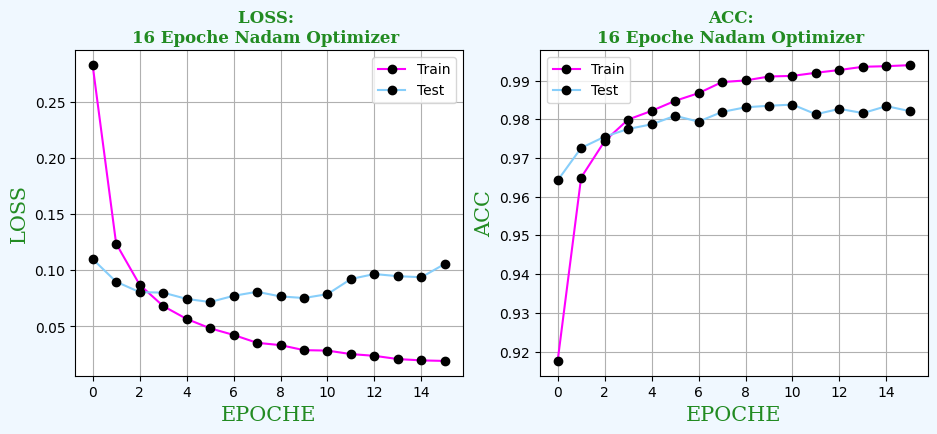

313/313 [==============================] - 1s 2ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


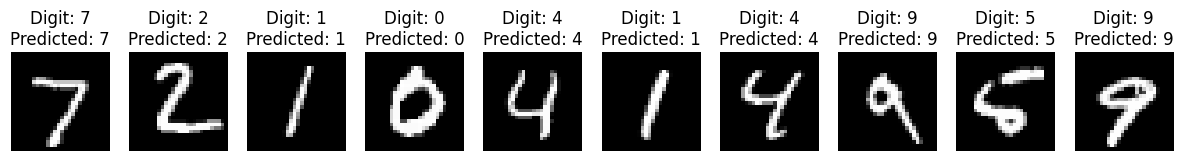


Test loss: 0.07068054378032684
Test accuracy: 0.9782999753952026


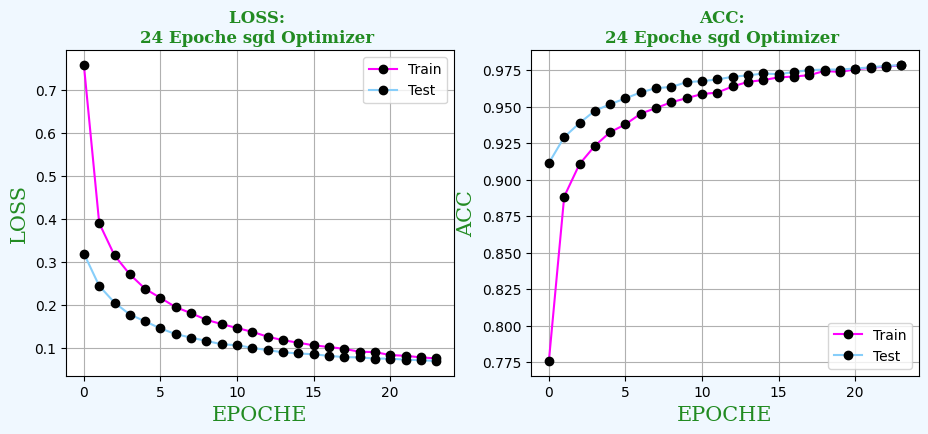

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


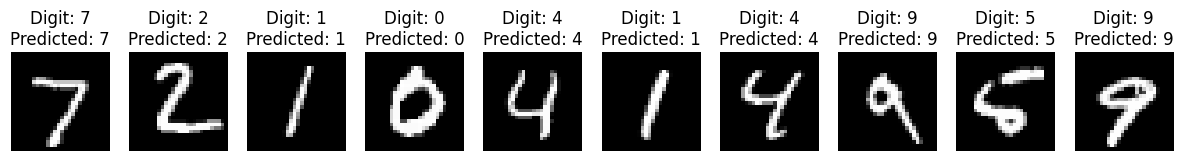


Test loss: 0.5169066190719604
Test accuracy: 0.8794999718666077


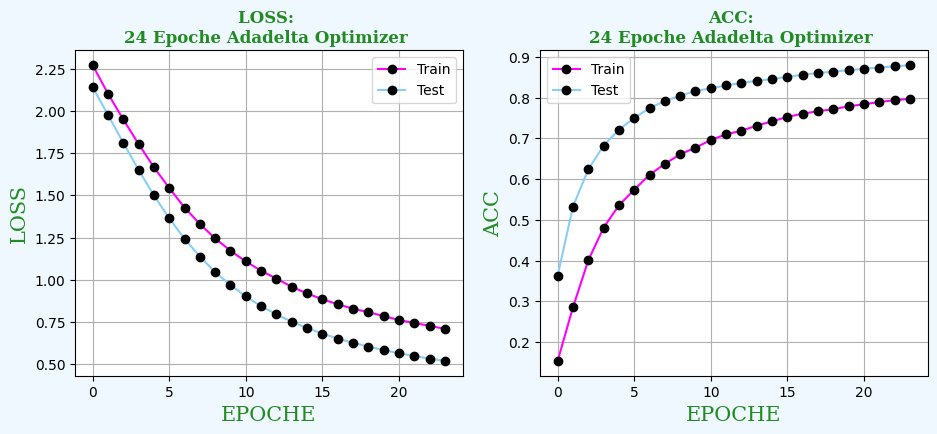

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


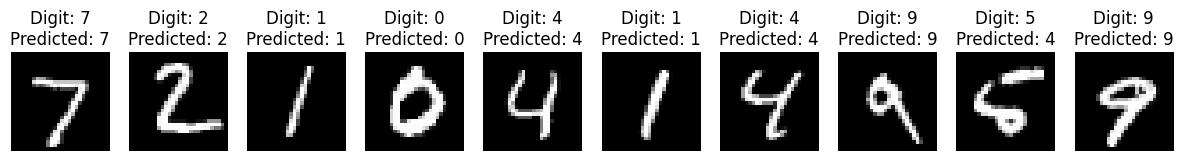


Test loss: 0.1432231068611145
Test accuracy: 0.9815999865531921


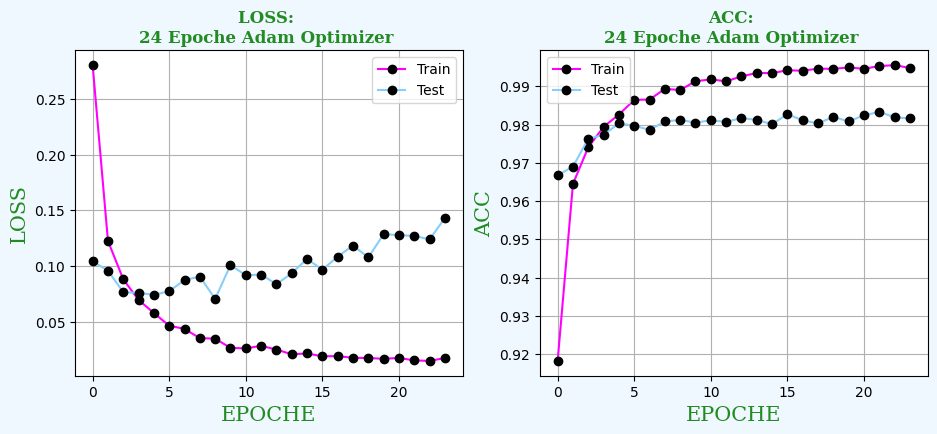

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


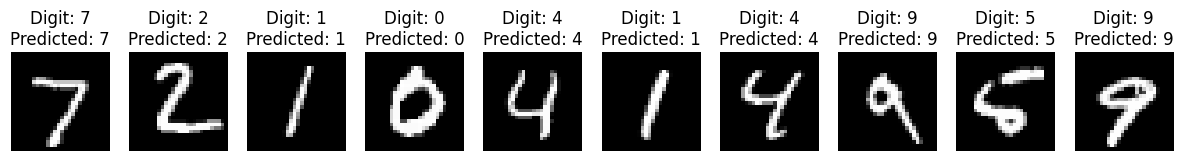


Test loss: 0.13194149732589722
Test accuracy: 0.9824000000953674


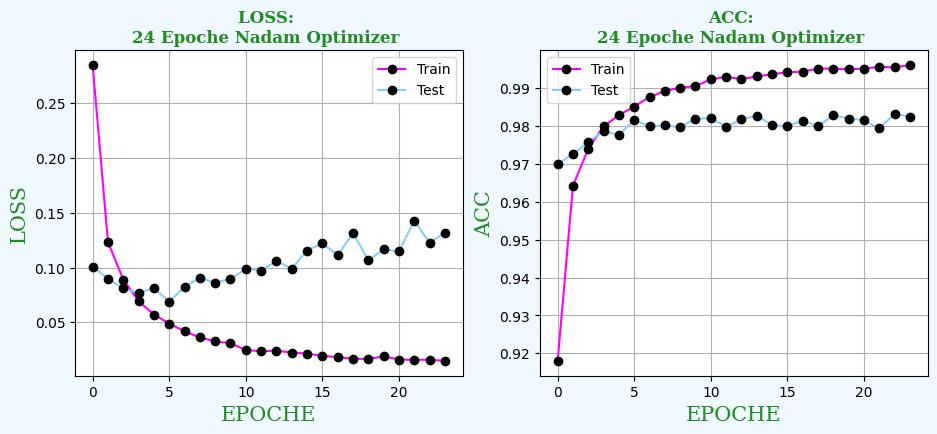

313/313 [==============================] - 1s 3ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PREDIZIONI DATA:


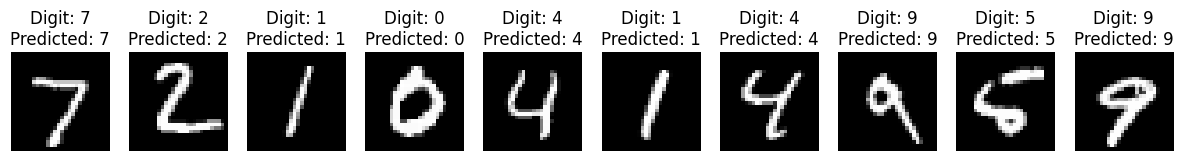

In [6]:
#SETTIAMO I PARAMETRI DEL PLOT:
r=len(optimizers)*len(epochs)#SUBPLOT DISTRIBUITI SU NUMERO COLONNE PARI AL PRODOTTO TRA GLI OTTIMIZZATORE E LE EPOCHE 
c=2 #SUBPLOT DISTRIBUITI SU COLONNE
conta=1



for e in epochs:
    for o in optimizers:
        #NON METTENDO LA GENERAZIONE DATI AD OGNI CICLO, IL FITI DA' PROBLEMI SULLE DIM. DEI VECTOR
        (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
     


        # reshape data, it could depend on Keras backend
        X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #DIVENTANO VECTOR 28*28
        X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

        # cast floats to single precision
        X_train = X_train.astype('float32')#da int a float
        X_test = X_test.astype('float32')

        # cosi' ho vettori di componenti da 0 a 1
        X_train /= 255
        X_test /= 255

        # convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
        #scrivo le label di binario per poter usare la categorical crossentropy
        Y_train = keras.utils.to_categorical(Y_train, num_classes)
        Y_test = keras.utils.to_categorical(Y_test, num_classes)
        #print('X_train shape:', X_train.shape) #60k vettori da 784 componenti
        #print('Y_train shape:', Y_train.shape) #10k vettori da 784 componenti
        
        
        # create the deep neural net
        model_DNN = compile_model(o)

        # TRAINING DNN
        history = model_DNN.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=e,
                  verbose=0, validation_data=(X_test, Y_test))

        # VALUTAZIONE PERFORMACE
        score = model_DNN.evaluate(X_test, Y_test, verbose=0)

        # STAMPA PRESTAZIONI
        print()
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        # summarize history for loss
        plt.figure(figsize=(11,5*r), facecolor = "AliceBlue")
        plt.subplot(r, c, conta)           
        plt.title('LOSS: \n'+str(e)+' Epoche '+str(o)+' Optimizer ', fontweight = "bold", family= "serif" ,color = "ForestGreen")
        plt.plot(history.history['loss'], color = "Magenta", marker = "o", mec = "black", mfc = "black")
        plt.plot(history.history['val_loss'], "LightSkyBlue", marker = "o", mec = "black", mfc = "black")
        font = {'family':'serif','color':'ForestGreen','size':15}
        plt.ylabel("LOSS", fontdict = font)
        plt.xlabel("EPOCHE", fontdict = font)
        plt.grid(True)
        plt.legend(['Train', 'Test'], loc='best')
        # summarize history for accuracy
        plt.subplot(r, c, conta+1)
        plt.title('ACC: \n'+str(e)+' Epoche '+str(o)+' Optimizer ', fontweight = "bold", family= "serif" ,color = "ForestGreen")
        plt.plot(history.history['accuracy'], color = "Magenta", marker = "o", mec = "black", mfc = "black")
        plt.plot(history.history['val_accuracy'], "LightSkyBlue", marker = "o", mec = "black", mfc = "black")
        font = {'family':'serif','color':'ForestGreen','size':15}
        plt.ylabel("ACC", fontdict = font)
        plt.xlabel("EPOCHE", fontdict = font)
        plt.grid(True)
        plt.legend(['Train', 'Test'], loc='best')
        
        
        plt.show()

        #STAMPA DIGITS e PREDIZIONI:
        predictions = model_DNN.predict(X_test)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print ('PREDIZIONI DATA:')
        plt.figure(figsize=(15, 15)) 
        for i in range(10):    
            ax = plt.subplot(2, 10, i + 1)    
            plt.imshow(X_test[i, :, :, 0], cmap='gray')    
            plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
            plt.axis('off') 
        plt.show()
        
        conta=conta+2;

Sebbene in generale otteniamo ottimi risultati, quanto si nota e' che l'unico ottimizzatore a predirre correttamente tutti i numeri quella che fa uso come ottimizzatore:Nadam oppure, una vulta cresciute le epoche, pure loSGD.

<h2><font color = 'LimeGreen'>ESERCIZIO 12.2: Classificazione Immagini e Reti Convoluzionali</font></h2>

Nel caso precedente abbiamo considerato ogni dato image del MNIST come un vettore 1D, d'altro canto l'approccio adoperato puo' essere migliorato. Infatti si sa che in ognuna delle cifre scritta a mano ci sono correlazioni spaziali locali tra i vari pixel e vale anche e' soddisfatta la proprieta' di invarianza traslazionale; l'idea e' sfruttare questi simmetrie di localita' e T-invarianza per migliorare l'accuratezza del nostro modello di classificazione.
Per potere servirsi opportunamente di queste simmetrie si introducono cosi' le cosiddette reti neurali convoluzionali, in grado appunto, si ribadisce, di sfruttare invarianze del sistema per efficientare la rete neurale.



Definiamo, come prima, le dimensioni delle immagini e il numero di neuroni del leyer di output.

In [22]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

#INFORMAZIONI: 
img_rows, img_cols = 28, 28 # DIMENSIONI IMMAGINI DI INPUT IN PIXEL
num_classes = 10 # LABEL OUTPUT: NUMERO DA 0 A 9 PER UN TOTALE DI 10 CLASSI

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

Convertiamolo in un vector di dimensione 28*28 e costruiamo il dataset, vale sempre il bisogno di dividerlo in dati di training e di validazione.

In [23]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

# LOADING DATASET DATI+LABEL: TRAINING E TEST
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print('X_train shape:', X_train.shape) # l'input
print('Y_train shape:', Y_train.shape) # label, ovvero gli output
print('X_test shape:', X_test.shape) # l'input
print('Y_test shape:', Y_test.shape) # label, ovvero gli output
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")

# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

X_train shape: (60000, 784)
X_test shape: (10000, 784)


Scriviamo quindi la struttura del dataset:

In [24]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #
#keras.backend.image_data_format: Returns the default image data format convention.
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print('X_train shape:', X_train.shape) # l'input
print('Y_train shape:', Y_train.shape) # label, ovvero gli output
print('X_test shape:', X_test.shape) # l'input
print('Y_test shape:', Y_test.shape) # label, ovvero gli output
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

60000 train samples
10000 test samples

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



Definiamo numero di epoche e batch_size:

In [25]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
# training parameters
batch_size = 32
epochs = 20
print("batch_size = ", batch_size)
print("epochs = ", epochs)
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

batch_size =  32
epochs =  20

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



Costruiamo architettura convulational neural network

1. Conv2D leyer convoluzionale: fa' in ioutput ancora uno shape2D
2. MaxPooling2D: procedura con cui l'informazione spaziale viene ridotta sostituendo una porzione dell'immagine con un solo pixel il cui valore corrisponde al massimo tra quelli presenti nella regione iniziale;
3. Dropout: disattiva neurono per irrobustire rete ed evitare overfitting
4. Flatten: converte l'informazione 2D in un vettore 1D su cui si puo' lavorare con un DNN e i suoi layer densi.

In [26]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #
def create_CNN():
    

    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space cioe' 5x5)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape)) #primi 10 filtri
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(25, kernel_size=(5, 5), activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    
    model.add(Dense(10, activation='softmax')) 
    #we need a soft-max layer with num_classes=10 possible outputs as output layer
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['acc'])
    return model
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

Training

In [27]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #

print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
# create the deep conv netimport numpy as np

model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Epoch 1/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.4418 - acc: 0.8636 - val_loss: 0.1848 - val_acc: 0.9624
Epoch 2/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1502 - acc: 0.9535 - val_loss: 0.1185 - val_acc: 0.9722
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1133 - acc: 0.9648 - val_loss: 0.0910 - val_acc: 0.9798
Epoch 4/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0951 - acc: 0.9706 - val_loss: 0.0763 - val_acc: 0.9824
Epoch 5/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0842 - acc: 0.9738 - val_loss: 0.0721 - val_acc: 0.9842
Epoch 6/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0761 - acc: 0.9764 - val_loss: 0.0637 - val_acc: 0.9851
Epoch 7/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0696 - acc: 0.9787 - val_loss: 0.0578 - val_acc: 0.9867
Epoch 8/20
1875/

Valutiamo il modello sui dati di test:

In [28]:
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
313/313 [==============================] - 1s 4ms/step - loss: 0.0354 - acc: 0.9905

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Test loss: 0.035365477204322815
Test accuracy: 0.9904999732971191

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



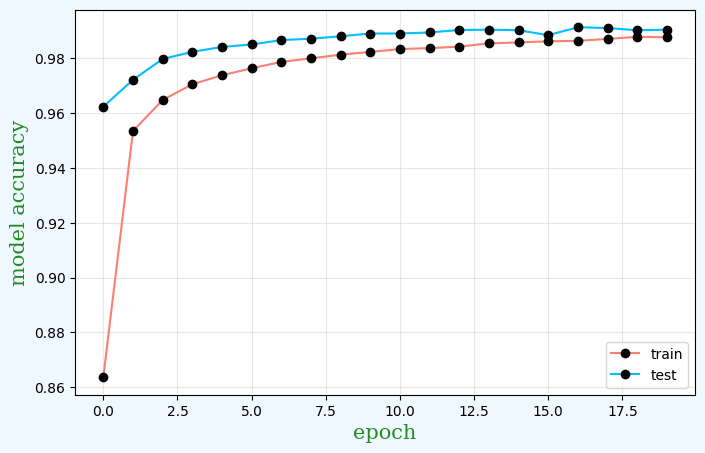

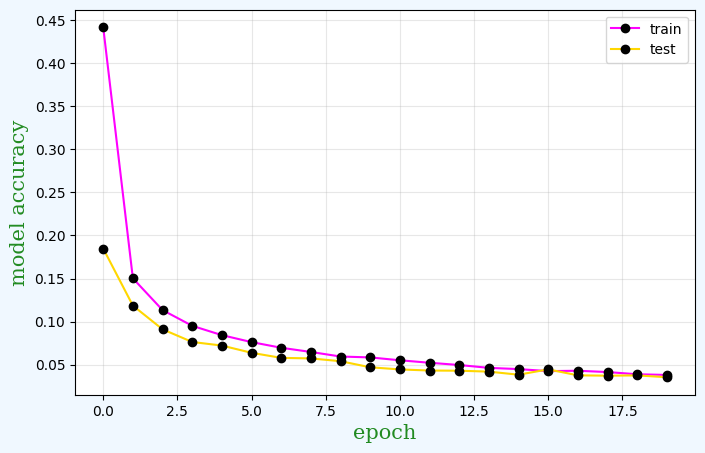

In [29]:
# summarize history for accuracy
plt.figure(figsize=(8,5), facecolor = "AliceBlue")
plt.plot(history.history['acc'], color = "Salmon", marker = "o", mec = "black", mfc = "black")
plt.plot(history.history['val_acc'], color = "DeepSkyBlue", marker = "o", mec = "black", mfc = "black")
font = {"family":"serif", "color":"ForestGreen", "size":"15"}
plt.ylabel('model accuracy', fontdict=font)
plt.xlabel('epoch', fontdict = font)
plt.legend(['train', 'test'], loc='best')
plt.grid(True, alpha = 0.3)
plt.savefig('MA.png')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,5), facecolor = "AliceBlue")
plt.plot(history.history['loss'], color = "Fuchsia", marker = "o", mec = "black", mfc = "black")
plt.plot(history.history['val_loss'], color = "Gold", marker = "o", mec = "black", mfc = "black")
font = {"family":"serif", "color":"ForestGreen", "size":"15"}
plt.ylabel('model accuracy', fontdict=font)
plt.xlabel('epoch', fontdict = font)
plt.legend(['train', 'test'], loc='best')
plt.grid(True, alpha = 0.3)

plt.savefig('M.png')
plt.show()

313/313 [==============================] - 1s 4ms/step


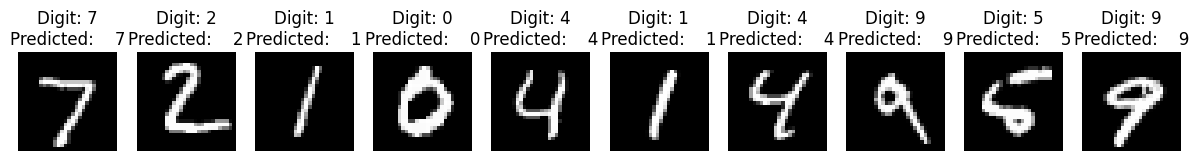

In [30]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

<h2><font color = 'LimeGreen'>ESERCIZIO 12.3: Classificazione Immagini Scritti a Mano</font></h2>

1/1 [==============================] - 0s 18ms/step


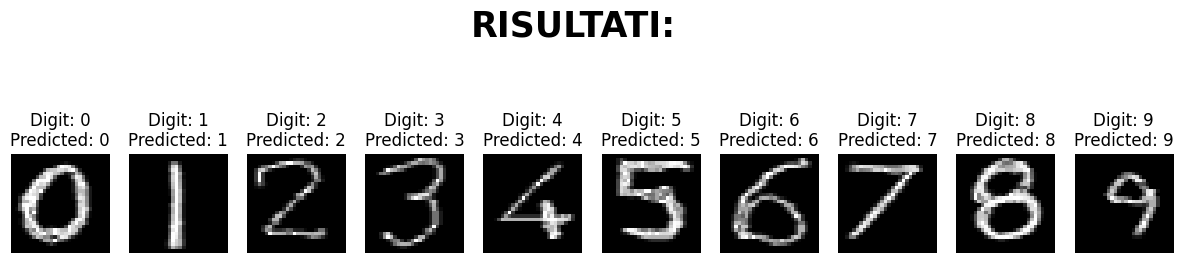

In [36]:
digit_filenames = [ "CIFRE/0.png",
                    "CIFRE/1.png",
                    "CIFRE/2.png",
                    "CIFRE/3.png",
                    "CIFRE/4.png",
                    "CIFRE/5.png",
                    "CIFRE/6.png",
                    "CIFRE/7.png",
                    "CIFRE/8.png",
                    "CIFRE/9.png", ]
data = []

for digit_filename in digit_filenames:
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load()
    img = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            img[i,j]=pix[j,i]/255
    data.append(img)

# I use the previously trained CDNN to predict the digit:

predictions = [0,0,0,0,0,0,0,0,0,0]
for i in range(0,10):
    data[i] = data[i].reshape(1,xdim, ydim, 1)
    predictions[i] = model_CNN.predict(data[i])
    data[i] = data[i].reshape(xdim,ydim)

plt.figure(figsize=(15,4))
plt.suptitle("RISULTATI:", fontsize = 25, fontweight = 'bold')
for i in range(10):    
    ax = plt.subplot(1, 10, i + 1)    
    plt.imshow(data[i], cmap='gray')    
    plt.title("Digit: "+str(i)+"\nPredicted: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 


plt.show()